In [1]:
# Import data
import pandas as pd

train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [2]:
# EDA
def describe_data(df):
    
    print('Data types:')
    print(df.dtypes)

    print()
    
    print('Rows and columns:')
    print(df.shape)
    
    print()
    
    print('Column names:')
    print(df.columns)
    
    print()
    
    print('Null values:')
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))

describe_data(train_data)

Data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Rows and columns:
(8693, 14)

Column names:
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

Null values:
PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64


1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: group_size, dtype: int64


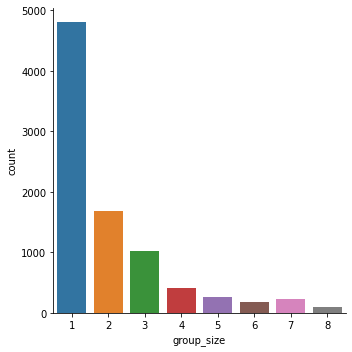

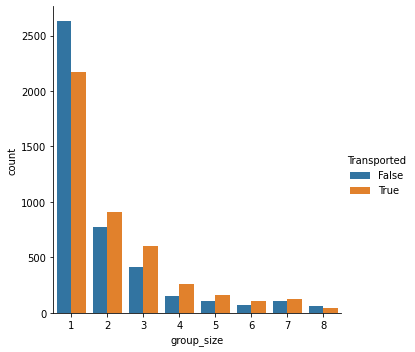

In [3]:
# Preprocess PassengerId
import seaborn as sns

# Train data
# Split gggg and pp
gggg_pp = train_data['PassengerId'].apply(lambda x: x.split('_')).values
gggg = list(map(lambda x: x[0], gggg_pp))
pp = list(map(lambda x: x[1], gggg_pp))
train_data['gggg'] = gggg
train_data['pp'] = pp

# For each gggg, what is max pp
train_data['pp'] = train_data['pp'].astype('int64')
train_data['group_size'] = train_data.groupby(['gggg'])['pp'].transform(max)

# Does group size have effect on target
print(train_data['group_size'].value_counts())
sns.catplot(x='group_size', kind='count', data=train_data)
sns.catplot(x='group_size', kind='count', hue='Transported', data=train_data)

# Test data
gggg_pp = test_data['PassengerId'].apply(lambda x: x.split('_')).values
gggg = list(map(lambda x: x[0], gggg_pp))
pp = list(map(lambda x: x[1], gggg_pp))
test_data['gggg'] = gggg
test_data['pp'] = pp

test_data['pp'] = test_data['pp'].astype('int64')
test_data['group_size'] = test_data.groupby(['gggg'])['pp'].transform(max)

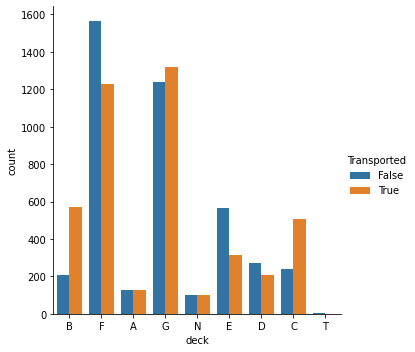

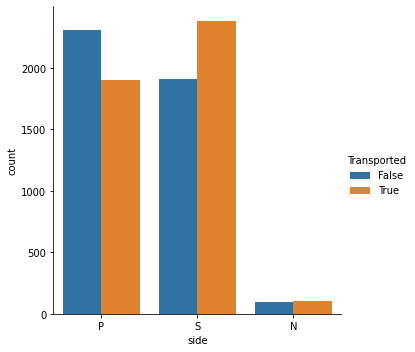

In [4]:
# Preprocess Cabin

# Train data
# Split values
train_data['Cabin'].fillna('N/N/N', inplace=True) # Split won't work unless you fill in missing values
deck_num_side = train_data['Cabin'].apply(lambda x: x.split('/'))

# Deck
deck = list(map(lambda x: x[0], deck_num_side))
train_data['deck'] = deck
sns.catplot(x='deck', kind='count', hue='Transported', data=train_data)

# Side
side = list(map(lambda x: x[2], deck_num_side))
train_data['side'] = side
sns.catplot(x='side', kind='count', hue='Transported', data=train_data)

# Test data
test_data['Cabin'].fillna('N/N/N', inplace=True) # Split won't work unless you fill in missing values
deck_num_side = test_data['Cabin'].apply(lambda x: x.split('/'))

# Deck
deck = list(map(lambda x: x[0], deck_num_side))
test_data['deck'] = deck

# Side
side = list(map(lambda x: x[2], deck_num_side))
test_data['side'] = side

In [5]:
# Create new feature for total spent on amenities
amenities_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_data['amenities'] = train_data[amenities_cols].sum(axis=1)
test_data['amenities'] = test_data[amenities_cols].sum(axis=1)

# Create new feature did passenger spend any on amenities
train_data['no_amenities'] = train_data['amenities']==0
test_data['no_amenities'] = train_data['amenities']==0

In [6]:
# Separate target from predictors
y_train = train_data.Transported
X_train = train_data.drop(['PassengerId', 'Cabin', 'Name', 'gggg', 'pp', 'Transported'], axis=1)
X_test = test_data.drop(['PassengerId', 'Cabin', 'Name', 'gggg', 'pp', ], axis=1)

# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and X_train[cname].dtype == 'object']

#Select numerical columns
numerical_cols = [cname for cname in X_train.columns if  X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols]
X_test = X_test[my_cols]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

In [8]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, learning_rate=0.05)

In [9]:
import numpy as np

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)    
                             ])

# Preprocessing of training data, fit model
my_pipeline.fit(X_train, y_train)

# Preprocessing of test data, get predictions
preds = my_pipeline.predict(X_test)
preds = preds.astype(np.bool) # Convert 0, 1 to boolean

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': preds})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
